In [1]:
import torch
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
!micromamba activate nlp

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'Tesla V100S-PCIE-32GB'

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
DEVICE_CPU = torch.device('cpu')

DEVICE

device(type='cpu')

In [3]:
def get_model():
    # Загрузка модели ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Убираем последний полносвязный слой (FC)
    model.fc = torch.nn.Identity()

    # Выключаем вычисление градиентов и включаем режим оценки
    for param in model.parameters():
        param.requires_grad = False
    model.eval()

    model = model.to(DEVICE)
    return model


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.permute(1, 2, 0))
    plt_ax.grid(False)


def preview(images, labels, rows=3, cols=3):
    """Предпросмотр первых изображений из набора."""
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))  # Создаем сетку для отображения изображений
    num_images = min(len(images), rows*cols)  # Ограничиваем количество отображаемых изображений
    for idx in range(num_images):
        row_idx = idx // cols
        col_idx = idx % cols
        ax = axes[row_idx][col_idx]
        imshow(images[idx], title=f"{labels[idx]}", plt_ax=ax)  # Отображаем изображение с подписью класса
    plt.show()

In [4]:
# Трансформация изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Теперь делаем изображение трёхканальным
    transforms.ToTensor(),
])

# Загрузка FashionMNIST
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

In [5]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [6]:
model = get_model()

In [ ]:
# Извлекаем признаки
features_list = []
labels_list = []

def process_dataset_from_model():
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(DEVICE)
            outputs = model(images)
            images = images.to(DEVICE_CPU)
            features_list.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

process_dataset_from_model()


# Обрабатываем полученные признаки и метки
all_features = np.concatenate(features_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)

In [149]:
def process_one_image_from_model(img):
    with torch.no_grad():
        image = img.to(DEVICE)
        outputs = model(image)
        image = image.to(DEVICE_CPU)
        image_after_model = outputs.cpu().numpy()
        return image_after_model

In [150]:
print("Размер массива признаков:", all_features.shape)
print("Количество классов:", len(np.unique(all_labels)))

Размер массива признаков: (60000, 2048)
Количество классов: 10


# Save vector dataset

In [151]:
import pickle

In [20]:
with open('fashionmnist_features.pkl', 'wb') as f:
    pickle.dump(all_features, f)


with open('fashionmnist_labels.pkl', 'wb') as f:
    pickle.dump(all_labels, f)

print("Признаки успешно сохранены!")

Признаки успешно сохранены!


# Load vector dataset

In [152]:
with open('fashionmnist_features.pkl', 'rb') as f:
    all_features = pickle.load(f)

# Vector searching

In [24]:
!pip install faiss-cpu

Looking in indexes: https://nexus-docker-proxy.biotech.biotc.ru/repository/pypi-all/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 68.4 MB/s  0:00:00m0:00:01


In [153]:
import faiss

In [154]:
norm_all_features = all_features / np.linalg.norm(all_features, axis=1, keepdims=True)


In [28]:
norm_all_features[0]

array([0.01982925, 0.        , 0.05013845, ..., 0.00153462, 0.        ,
       0.01935305], shape=(2048,), dtype=float32)

In [155]:
index = faiss.IndexFlatL2(norm_all_features.shape[1])

In [156]:
index.add(norm_all_features)

In [157]:
K = 10

def search_nearest_neighbors(img):
    """
    Функция поиска ближайших соседей.
    :param query_vector: Вектор-запрос (предварительно нормализованный!)
    :param k: Количество ближайших соседей
    :return: индексы ближайших соседей и расстояния до них
    """
    query_vector = img.reshape(1, -1)
    
    distances, indices = index.search(query_vector.reshape(1, -1), K)
    return indices.flatten(), distances.flatten()

In [105]:
CURRENT_ITEM = 0

nearest_indices, nearest_distances = search_nearest_neighbors(norm_all_features[CURRENT_ITEM])


print("Индексы ближайших соседей:", nearest_indices)
print("Расстояния до ближайших соседей:", nearest_distances)

Индексы ближайших соседей: [    0 50124 20525 27125 19681 43823 41025 42044 19684 11872]
Расстояния до ближайших соседей: [0.         0.1723772  0.17792296 0.18009254 0.18308404 0.18316257
 0.18481298 0.18615171 0.18699257 0.18758763]


In [107]:
images = []
labels = []

for i in nearest_indices[1:]:
    images.append(dataset[i][0])
    labels.append(dataset[i][1])

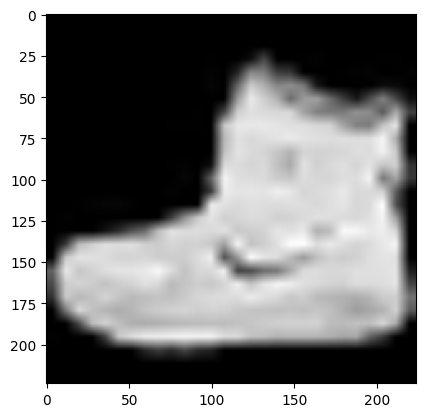

In [108]:
current_image = dataset[CURRENT_ITEM][0].permute(1, 2, 0)

plt.imshow(current_image)
plt.show()

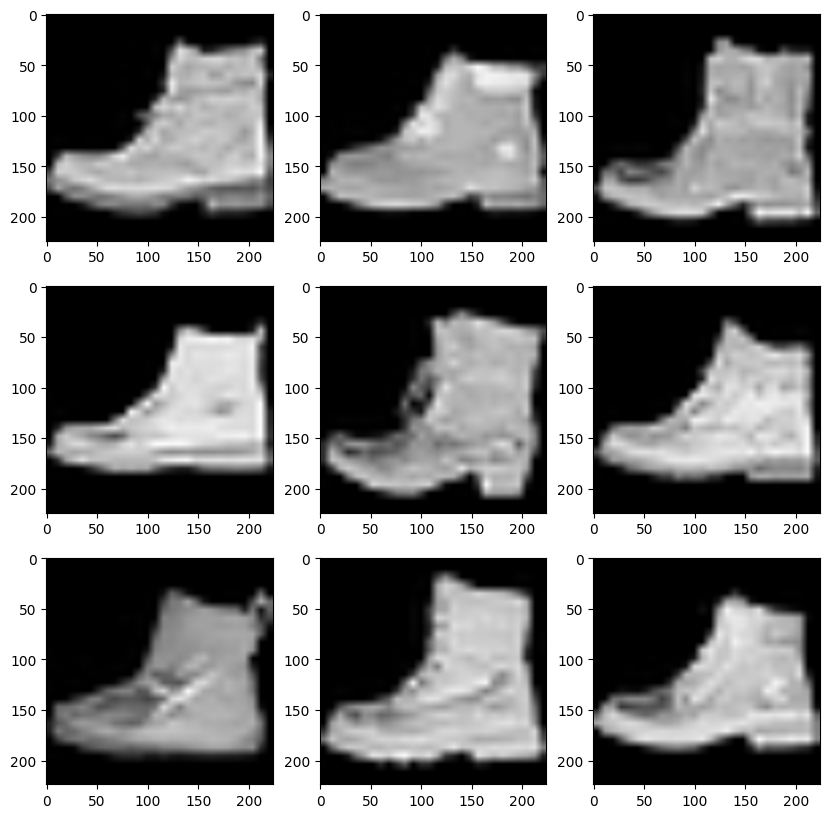

In [109]:
preview(images, labels)

# Downloading real image

In [110]:
from PIL import Image

In [131]:
def preprocess_image(image_path):
    image = Image.open(image_path)  # Открытие изображения
    transformed_image = transform(image)  # Применяем трансформации
    return transformed_image.unsqueeze(0)

In [ ]:
image_path = "/home/froschin/work/ML/fashion/1636172403_30-mykaleidoscope-ru-p-zhenskaya-zimnyaya-verkhnyaya-odezhda-devu-31-1000x690.jpg"

transformed_img_image = preprocess_image(image_path)

In [ ]:
image_after_model = process_one_image_from_model(transformed_img_image)

In [ ]:
nearest_indices, nearest_distances = search_nearest_neighbors(image_after_model)

images = []
labels = []

for i in nearest_indices:
    images.append(dataset[i][0])
    labels.append(dataset[i][1])

In [128]:
nearest_indices

array([22099, 50119, 14710, 41877, 38298, 20738,  3712, 50080, 21057,
       57589])

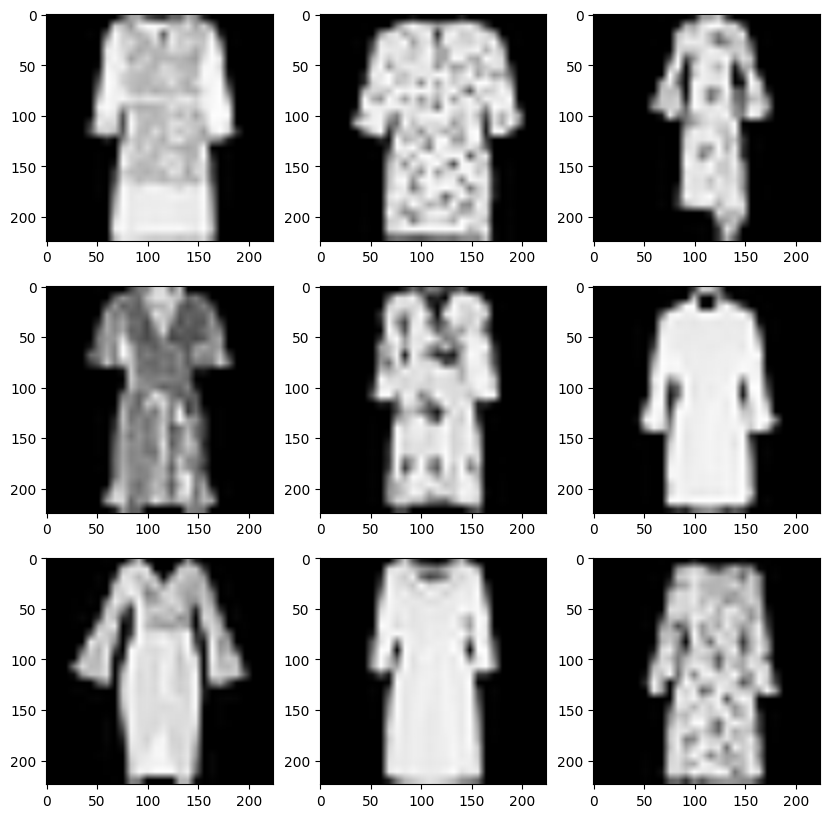

In [129]:
preview(images, labels)

# Downloading real image (from mask)

In [161]:
def process_image_and_preview(image_path):
    transformed_img_image = preprocess_image(image_path)

    image_after_model = process_one_image_from_model(transformed_img_image)

    nearest_indices, nearest_distances = search_nearest_neighbors(image_after_model)

    images = []
    labels = []

    for i in nearest_indices:
        images.append(dataset[i][0])
        labels.append(dataset[i][1])
    
    preview(images, labels)
    
    return images, labels

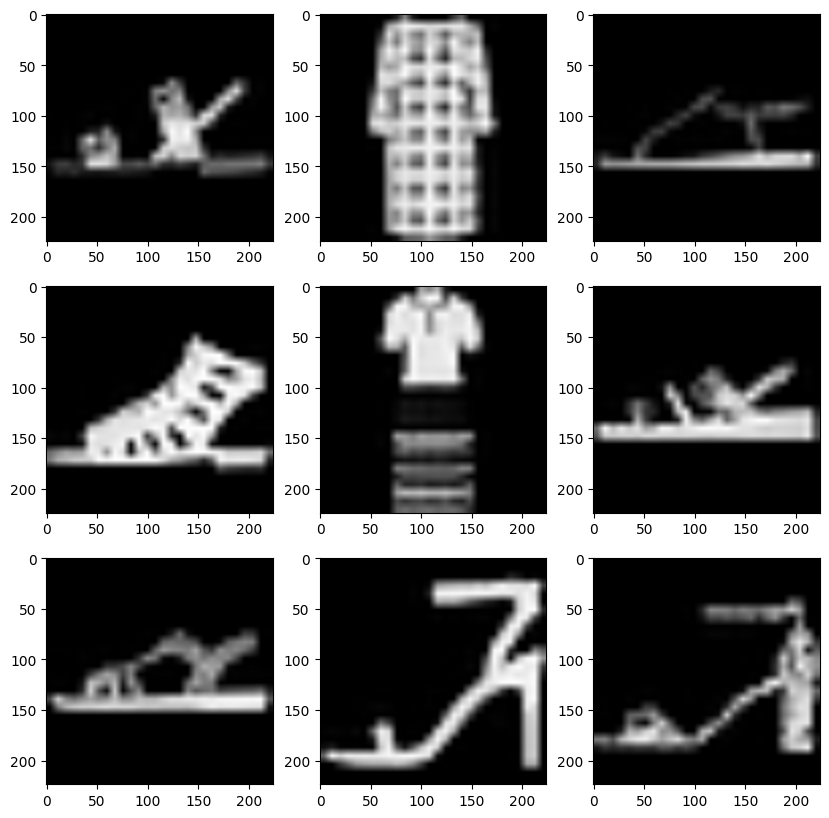

In [162]:
images, labels = process_image_and_preview("/home/froschin/work/ML/fashion/output_1.png")